In [1]:
import os
import polars as pl
from datetime import date
from rocrate.rocrate import ROCrate
from rocrate.model import (
    Person,
    File,
    Dataset,
    ComputationalWorkflow,
    ContextEntity,
)

In [2]:
def get_file_size(path):
    file_stats = os.stat(path)
    size = file_stats.st_size
    if size >= 1024*1024:
        return f"{round(file_stats.st_size / (1024*1024), 2)}MB"
    elif size >= 1024:
        return f"{round(file_stats.st_size / 1024, 2)}KB"
    else:         
        return f"{file_stats.st_size}B"

## Read in Data

### Census Data for Zip Codes

In [3]:
in_crate_data = ROCrate("../../metastore/US2020CensusZCTA5PA/")

In [4]:
file_uris= [file["@id"] for file in in_crate_data.mainEntity.properties().get("hasParts", [])]
file_uris

['file:///data/extract/US2020CensusZCTA5PA/USCensusDecennialDP2020DP1.csv']

In [5]:
input_data_path = file_uris[0].replace("file://", "../..")
input_data_path

'../../data/extract/US2020CensusZCTA5PA/USCensusDecennialDP2020DP1.csv'

In [6]:
df = pl.scan_csv(input_data_path)

In [7]:
df.schema

OrderedDict([('GEO_ID', String),
             ('NAME', String),
             ('DP1_0001C', String),
             ('DP1_0002C', String),
             ('DP1_0003C', String),
             ('DP1_0004C', String),
             ('DP1_0005C', String),
             ('DP1_0006C', String),
             ('DP1_0007C', String),
             ('DP1_0008C', String),
             ('DP1_0009C', String),
             ('DP1_0010C', String),
             ('DP1_0011C', String),
             ('DP1_0012C', String),
             ('DP1_0013C', String),
             ('DP1_0014C', String),
             ('DP1_0015C', String),
             ('DP1_0016C', String),
             ('DP1_0017C', String),
             ('DP1_0018C', String),
             ('DP1_0019C', String),
             ('DP1_0020C', String),
             ('DP1_0021C', String),
             ('DP1_0022C', String),
             ('DP1_0023C', String),
             ('DP1_0024C', String),
             ('DP1_0025C', String),
             ('DP1_0026C', String),


In [8]:
df.head().collect()

GEO_ID,NAME,DP1_0001C,DP1_0002C,DP1_0003C,DP1_0004C,DP1_0005C,DP1_0006C,DP1_0007C,DP1_0008C,DP1_0009C,DP1_0010C,DP1_0011C,DP1_0012C,DP1_0013C,DP1_0014C,DP1_0015C,DP1_0016C,DP1_0017C,DP1_0018C,DP1_0019C,DP1_0020C,DP1_0021C,DP1_0022C,DP1_0023C,DP1_0024C,DP1_0025C,DP1_0026C,DP1_0027C,DP1_0028C,DP1_0029C,DP1_0030C,DP1_0031C,DP1_0032C,DP1_0033C,DP1_0034C,DP1_0035C,…,DP1_0125P,DP1_0126P,DP1_0127P,DP1_0128P,DP1_0129P,DP1_0130P,DP1_0131P,DP1_0132P,DP1_0133P,DP1_0134P,DP1_0135P,DP1_0136P,DP1_0137P,DP1_0138P,DP1_0139P,DP1_0140P,DP1_0141P,DP1_0142P,DP1_0143P,DP1_0144P,DP1_0145P,DP1_0146P,DP1_0147P,DP1_0148P,DP1_0149P,DP1_0150P,DP1_0151P,DP1_0152P,DP1_0153P,DP1_0154P,DP1_0155P,DP1_0156P,DP1_0157P,DP1_0158P,DP1_0159P,DP1_0160P,
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Geography""","""Geographic Are…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…","""Count!!SEX AND…",…,"""Percent!!RELAT…","""Percent!!RELAT…","""Percent!!RELAT…","""Percent!!RELAT…","""Percent!!RELAT…","""Percent!!RELAT…","""Percent!!RELAT…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSE…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!VACAN…","""Percent!!VACAN…","""Percent!!HOUSI…","""Percent!!HOUSI…","""Percent!!HOUSI…",null
"""0500000US42101…","""Philadelphia C…","""1603797""","""88967""","""91714""","""92181""","""99181""","""130359""","""158444""","""147435""","""113306""","""92683""","""84442""","""89756""","""93616""","""92641""","""77686""","""59567""","""38949""","""25955""","""26915""","""1313194""","""1278362""","""1206416""","""283226""","""229072""","""760383""","""45345""","""46676""","""47089""","""49571""","""62296""","""75078""","""71159""","""54661""","""44354""","""40323""",…,"""2.9""","""0.8""","""0.5""","""0.3""","""2.1""","""1.0""","""1.1""","""100.0""","""27.3""","""10.1""","""8.2""","""2.2""","""24.2""","""16.1""","""4.0""","""1.7""","""40.3""","""19.4""","""7.5""","""7.9""","""26.6""","""27.0""","""100.0""","""90.5""","""9.5""","""3.7""","""0.5""","""0.8""","""0.5""","""0.3""","""3.6""","""(X)""","""(X)""","""100.0""","""48.2""","""51.8""",null
"""860Z200US15001…","""ZCTA5 15001""","""32299""","""1587""","""1805""","""1815""","""1629""","""1536""","""1890""","""2051""","""2002""","""1866""","""1788""","""2127""","""2611""","""2746""","""2189""","""1735""","""1108""","""855""","""959""","""26745""","""26068""","""25141""","""8449""","""6846""","""15607""","""801""","""894""","""935""","""794""","""800""","""959""","""971""","""1086""","""936""","""894""",…,"""1.1""","""0.6""","""0.3""","""0.3""","""0.5""","""0.2""","""0.4""","""100.0""","""44.5""","""13.3""","""6.5""","""2.1""","""19.3""","""14.2""","""4.4""","""1.2""","""29.7""","""17.2""","""9.6""","""5.2""","""24.5""","""35.3""","""100

In [9]:
metric_abbr = {
    "Count": "cnt",
    "Percent": "pct",
}
pop_abbr = {
    "Total": "ttl",
    "Male": "m",
    "Female": "f",
}
rel_abbr = {
    "In households": "hhld",
    "In group quarters": "grp_quarters",
}
for col, temp in zip(df.columns, df.collect().row(0)):
    splits = temp.split("!!")
    if len(splits) >= 3:
        metric, metric_type, group = splits[:3]
        subgroups = splits[3:]
    else:
        continue
    if metric != "Count":
        continue
    if metric_type == "SEX AND AGE":
        pop_type = pop_abbr[group.split(" ")[0]]
        subgroups_str = "-".join([subgrouping.replace("years", "").replace(" ", "").lower() for subgrouping in subgroups])
        if len(subgroups_str) > 0:
            subgroups_str += "_"
        print(f"pl.col('{col}').alias('pop_{pop_type}_{subgroups_str}{metric_abbr[metric]}').cast(pl.Float64),  # {temp}")    
    elif metric_type == "RELATIONSHIP" and len(subgroups) > 1:
        first_subgroup = subgroups[0]
        first_subgroup_str = rel_abbr[first_subgroup]
        subgroups_str = "-".join([subgrouping.replace(":", "").replace(" ", "_").lower() for subgrouping in subgroups[1:]])
        if len(subgroups_str) > 0:
            subgroups_str += "_"
        print(f"pl.col('{col}').alias('rel_{first_subgroup_str}_{subgroups_str}{metric_abbr[metric]}').cast(pl.Float64),  # {temp}")
    elif metric_type == "HOUSING OCCUPANCY":
        count_type = "ttl"
        subgroups_str = "-".join([subgrouping.replace(",", "").replace(" ", "_").lower() for subgrouping in subgroups])
        if len(subgroups_str) > 0:
            subgroups_str += "_"
        print(f"pl.col('{col}').alias('housing_{count_type}_{subgroups_str}{metric_abbr[metric]}').cast(pl.Float64),  # {temp}")

pl.col('DP1_0001C').alias('pop_ttl_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population
pl.col('DP1_0002C').alias('pop_ttl_under5_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!Under 5 years
pl.col('DP1_0003C').alias('pop_ttl_5to9_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!5 to 9 years
pl.col('DP1_0004C').alias('pop_ttl_10to14_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!10 to 14 years
pl.col('DP1_0005C').alias('pop_ttl_15to19_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!15 to 19 years
pl.col('DP1_0006C').alias('pop_ttl_20to24_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!20 to 24 years
pl.col('DP1_0007C').alias('pop_ttl_25to29_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!25 to 29 years
pl.col('DP1_0008C').alias('pop_ttl_30to34_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!30 to 34 years
pl.col('DP1_0009C').alias('pop_ttl_35to39_cnt').cast

AttributeError: 'NoneType' object has no attribute 'split'

In [10]:
df[1:].head().collect()

GEO_ID,NAME,DP1_0001C,DP1_0002C,DP1_0003C,DP1_0004C,DP1_0005C,DP1_0006C,DP1_0007C,DP1_0008C,DP1_0009C,DP1_0010C,DP1_0011C,DP1_0012C,DP1_0013C,DP1_0014C,DP1_0015C,DP1_0016C,DP1_0017C,DP1_0018C,DP1_0019C,DP1_0020C,DP1_0021C,DP1_0022C,DP1_0023C,DP1_0024C,DP1_0025C,DP1_0026C,DP1_0027C,DP1_0028C,DP1_0029C,DP1_0030C,DP1_0031C,DP1_0032C,DP1_0033C,DP1_0034C,DP1_0035C,…,DP1_0125P,DP1_0126P,DP1_0127P,DP1_0128P,DP1_0129P,DP1_0130P,DP1_0131P,DP1_0132P,DP1_0133P,DP1_0134P,DP1_0135P,DP1_0136P,DP1_0137P,DP1_0138P,DP1_0139P,DP1_0140P,DP1_0141P,DP1_0142P,DP1_0143P,DP1_0144P,DP1_0145P,DP1_0146P,DP1_0147P,DP1_0148P,DP1_0149P,DP1_0150P,DP1_0151P,DP1_0152P,DP1_0153P,DP1_0154P,DP1_0155P,DP1_0156P,DP1_0157P,DP1_0158P,DP1_0159P,DP1_0160P,
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""0500000US42101…","""Philadelphia C…","""1603797""","""88967""","""91714""","""92181""","""99181""","""130359""","""158444""","""147435""","""113306""","""92683""","""84442""","""89756""","""93616""","""92641""","""77686""","""59567""","""38949""","""25955""","""26915""","""1313194""","""1278362""","""1206416""","""283226""","""229072""","""760383""","""45345""","""46676""","""47089""","""49571""","""62296""","""75078""","""71159""","""54661""","""44354""","""40323""",…,"""2.9""","""0.8""","""0.5""","""0.3""","""2.1""","""1.0""","""1.1""","""100.0""","""27.3""","""10.1""","""8.2""","""2.2""","""24.2""","""16.1""","""4.0""","""1.7""","""40.3""","""19.4""","""7.5""","""7.9""","""26.6""","""27.0""","""100.0""","""90.5""","""9.5""","""3.7""","""0.5""","""0.8""","""0.5""","""0.3""","""3.6""","""(X)""","""(X)""","""100.0""","""48.2""","""51.8""",null
"""860Z200US15001…","""ZCTA5 15001""","""32299""","""1587""","""1805""","""1815""","""1629""","""1536""","""1890""","""2051""","""2002""","""1866""","""1788""","""2127""","""2611""","""2746""","""2189""","""1735""","""1108""","""855""","""959""","""26745""","""26068""","""25141""","""8449""","""6846""","""15607""","""801""","""894""","""935""","""794""","""800""","""959""","""971""","""1086""","""936""","""894""",…,"""1.1""","""0.6""","""0.3""","""0.3""","""0.5""","""0.2""","""0.4""","""100.0""","""44.5""","""13.3""","""6.5""","""2.1""","""19.3""","""14.2""","""4.4""","""1.2""","""29.7""","""17.2""","""9.6""","""5.2""","""24.5""","""35.3""","""100.0""","""90.8""","""9.2""","""3.4""","""0.3""","""0.9""","""0.5""","""0.6""","""3.4""","""(X)""","""(X)""","""100.0""","""74.7""","""25.3""",null
"""860Z200US15003…","""ZCTA5 15003""","""11672""","""614""","""658""","""707""","""668""","""678""","""813""","""903""","""782""","""765""","""618""","""718""","""829""","""884""","""733""","""489""","""324""","""222""","""267""","""9528""","""9279""","""8895""","""2530""","""2035""","""5937""","""349""","""339""","""386""","""356""","""348""","""390""","""459""","""400""","""362""","""329""",…,"""0.2""","""0.0""","""0.0""","""0.0""","""0.2""","""0.1""","""0.1""","""100.0""","""35.4""","""11.1""","""8.4""","""3.0""","""25.4""","""19.3""","""5.6""","""1.7""","""30.8""","""16.9""","""7.7""","""6.2""","""24.9""","""30.4""","""100.0""","""86.9""","""13.1""","""3.3""","""0.2""","""1.6""","""1.2""","""0.5""","""6.3""","""(X)""","""(X)""","""100.0""","""61.4""","""38.6""",null
"""860Z200US15004…","""ZCTA5 15004""","""224""","""12""","""7""","""9""","""12""","""26""","""12""","""7""","""14""","""2""","""21""","""4""","""33""","""17""","""10""","""4""","""13""","""7""","""14""","""191""","""187""","""178""","""54""","""48""","""93""","""8""","""3""","""5""","""4""","""16""","""1""","""0""","""1""","""2""","""11""",…,"""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""100.0""","""51.0""","""4.9""","""5.9""","""3.9""","""15.7""","""14.7""","""3.9""","""1.0""","""27.5""","""17.6""","""4.

In [11]:
updated_df = (
    df[1:] # Remove first row describing columns values
    .filter(pl.col("NAME").str.contains("ZCTA5"))
    .select(
        pl.col("NAME").str.replace(pattern="ZCTA5 ", value="", literal=True).cast(pl.Int32).alias("ZCTA5"),
        pl.col('DP1_0001C').alias('pop_ttl_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population
        pl.col('DP1_0002C').alias('pop_ttl_under5_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!Under 5 years
        pl.col('DP1_0003C').alias('pop_ttl_5to9_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!5 to 9 years
        pl.col('DP1_0004C').alias('pop_ttl_10to14_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!10 to 14 years
        pl.col('DP1_0005C').alias('pop_ttl_15to19_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!15 to 19 years
        pl.col('DP1_0006C').alias('pop_ttl_20to24_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!20 to 24 years
        pl.col('DP1_0007C').alias('pop_ttl_25to29_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!25 to 29 years
        pl.col('DP1_0008C').alias('pop_ttl_30to34_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!30 to 34 years
        pl.col('DP1_0009C').alias('pop_ttl_35to39_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!35 to 39 years
        pl.col('DP1_0010C').alias('pop_ttl_40to44_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!40 to 44 years
        pl.col('DP1_0011C').alias('pop_ttl_45to49_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!45 to 49 years
        pl.col('DP1_0012C').alias('pop_ttl_50to54_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!50 to 54 years
        pl.col('DP1_0013C').alias('pop_ttl_55to59_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!55 to 59 years
        pl.col('DP1_0014C').alias('pop_ttl_60to64_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!60 to 64 years
        pl.col('DP1_0015C').alias('pop_ttl_65to69_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!65 to 69 years
        pl.col('DP1_0016C').alias('pop_ttl_70to74_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!70 to 74 years
        pl.col('DP1_0017C').alias('pop_ttl_75to79_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!75 to 79 years
        pl.col('DP1_0018C').alias('pop_ttl_80to84_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!80 to 84 years
        pl.col('DP1_0019C').alias('pop_ttl_85andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!85 years and over
        pl.col('DP1_0020C').alias('pop_ttl_16andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!Selected Age Categories!!16 years and over
        pl.col('DP1_0021C').alias('pop_ttl_18andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!Selected Age Categories!!18 years and over
        pl.col('DP1_0022C').alias('pop_ttl_21andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!Selected Age Categories!!21 years and over
        pl.col('DP1_0023C').alias('pop_ttl_62andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!Selected Age Categories!!62 years and over
        pl.col('DP1_0024C').alias('pop_ttl_65andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Total population!!Selected Age Categories!!65 years and over
        pl.col('DP1_0025C').alias('pop_m_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population
        pl.col('DP1_0026C').alias('pop_m_under5_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!Under 5 years
        pl.col('DP1_0027C').alias('pop_m_5to9_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!5 to 9 years
        pl.col('DP1_0028C').alias('pop_m_10to14_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!10 to 14 years
        pl.col('DP1_0029C').alias('pop_m_15to19_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!15 to 19 years
        pl.col('DP1_0030C').alias('pop_m_20to24_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!20 to 24 years
        pl.col('DP1_0031C').alias('pop_m_25to29_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!25 to 29 years
        pl.col('DP1_0032C').alias('pop_m_30to34_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!30 to 34 years
        pl.col('DP1_0033C').alias('pop_m_35to39_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!35 to 39 years
        pl.col('DP1_0034C').alias('pop_m_40to44_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!40 to 44 years
        pl.col('DP1_0035C').alias('pop_m_45to49_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!45 to 49 years
        pl.col('DP1_0036C').alias('pop_m_50to54_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!50 to 54 years
        pl.col('DP1_0037C').alias('pop_m_55to59_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!55 to 59 years
        pl.col('DP1_0038C').alias('pop_m_60to64_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!60 to 64 years
        pl.col('DP1_0039C').alias('pop_m_65to69_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!65 to 69 years
        pl.col('DP1_0040C').alias('pop_m_70to74_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!70 to 74 years
        pl.col('DP1_0041C').alias('pop_m_75to79_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!75 to 79 years
        pl.col('DP1_0042C').alias('pop_m_80to84_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!80 to 84 years
        pl.col('DP1_0043C').alias('pop_m_85andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!85 years and over
        pl.col('DP1_0044C').alias('pop_m_16andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!Selected Age Categories!!16 years and over
        pl.col('DP1_0045C').alias('pop_m_18andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!Selected Age Categories!!18 years and over
        pl.col('DP1_0046C').alias('pop_m_21andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!Selected Age Categories!!21 years and over
        pl.col('DP1_0047C').alias('pop_m_62andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!Selected Age Categories!!62 years and over
        pl.col('DP1_0048C').alias('pop_m_65andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Male population!!Selected Age Categories!!65 years and over
        pl.col('DP1_0049C').alias('pop_f_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population
        pl.col('DP1_0050C').alias('pop_f_under5_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!Under 5 years
        pl.col('DP1_0051C').alias('pop_f_5to9_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!5 to 9 years
        pl.col('DP1_0052C').alias('pop_f_10to14_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!10 to 14 years
        pl.col('DP1_0053C').alias('pop_f_15to19_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!15 to 19 years
        pl.col('DP1_0054C').alias('pop_f_20to24_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!20 to 24 years
        pl.col('DP1_0055C').alias('pop_f_25to29_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!25 to 29 years
        pl.col('DP1_0056C').alias('pop_f_30to34_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!30 to 34 years
        pl.col('DP1_0057C').alias('pop_f_35to39_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!35 to 39 years
        pl.col('DP1_0058C').alias('pop_f_40to44_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!40 to 44 years
        pl.col('DP1_0059C').alias('pop_f_45to49_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!45 to 49 years
        pl.col('DP1_0060C').alias('pop_f_50to54_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!50 to 54 years
        pl.col('DP1_0061C').alias('pop_f_55to59_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!55 to 59 years
        pl.col('DP1_0062C').alias('pop_f_60to64_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!60 to 64 years
        pl.col('DP1_0063C').alias('pop_f_65to69_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!65 to 69 years
        pl.col('DP1_0064C').alias('pop_f_70to74_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!70 to 74 years
        pl.col('DP1_0065C').alias('pop_f_75to79_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!75 to 79 years
        pl.col('DP1_0066C').alias('pop_f_80to84_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!80 to 84 years
        pl.col('DP1_0067C').alias('pop_f_85andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!85 years and over
        pl.col('DP1_0068C').alias('pop_f_16andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!Selected Age Categories!!16 years and over
        pl.col('DP1_0069C').alias('pop_f_18andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!Selected Age Categories!!18 years and over
        pl.col('DP1_0070C').alias('pop_f_21andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!Selected Age Categories!!21 years and over
        pl.col('DP1_0071C').alias('pop_f_62andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!Selected Age Categories!!62 years and over
        pl.col('DP1_0072C').alias('pop_f_65andover_cnt').cast(pl.Float64),  # Count!!SEX AND AGE!!Female population!!Selected Age Categories!!65 years and over
        pl.col('DP1_0114C').alias('rel_hhld_householder_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Householder
        pl.col('DP1_0115C').alias('rel_hhld_opposite-sex_spouse_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Opposite-sex spouse
        pl.col('DP1_0116C').alias('rel_hhld_same-sex_spouse_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Same-sex spouse
        pl.col('DP1_0117C').alias('rel_hhld_opposite-sex_unmarried_partner_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Opposite-sex unmarried partner
        pl.col('DP1_0118C').alias('rel_hhld_same-sex_unmarried_partner_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Same-sex unmarried partner
        pl.col('DP1_0119C').alias('rel_hhld_child_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Child [2]
        pl.col('DP1_0120C').alias('rel_hhld_child-under_18_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Child [2]!!Under 18 years
        pl.col('DP1_0121C').alias('rel_hhld_grandchild_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Grandchild
        pl.col('DP1_0122C').alias('rel_hhld_grandchild-under_18_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Grandchild!!Under 18 years
        pl.col('DP1_0123C').alias('rel_hhld_other_relatives_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Other relatives
        pl.col('DP1_0124C').alias('rel_hhld_nonrelatives_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In households!!Nonrelatives
        pl.col('DP1_0126C').alias('rel_grp_quarters_institutionalized_population_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In group quarters!!Institutionalized population:
        pl.col('DP1_0127C').alias('rel_grp_quarters_institutionalized_population-male_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In group quarters!!Institutionalized population:!!Male
        pl.col('DP1_0128C').alias('rel_grp_quarters_institutionalized_population-female_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In group quarters!!Institutionalized population:!!Female
        pl.col('DP1_0129C').alias('rel_grp_quarters_noninstitutionalized_population_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In group quarters!!Noninstitutionalized population:
        pl.col('DP1_0130C').alias('rel_grp_quarters_noninstitutionalized_population-male_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In group quarters!!Noninstitutionalized population:!!Male
        pl.col('DP1_0131C').alias('rel_grp_quarters_noninstitutionalized_population-female_cnt').cast(pl.Float64),  # Count!!RELATIONSHIP!!Total population!!In group quarters!!Noninstitutionalized population:!!Female
        pl.col('DP1_0147C').alias('housing_ttl_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units
        pl.col('DP1_0148C').alias('housing_ttl_occupied_housing_units_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units
        pl.col('DP1_0149C').alias('housing_ttl_vacant_housing_units_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units
        pl.col('DP1_0150C').alias('housing_ttl_vacant_housing_units-for_rent_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units!!For rent
        pl.col('DP1_0151C').alias('housing_ttl_vacant_housing_units-rented_not_occupied_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units!!Rented, not occupied
        pl.col('DP1_0152C').alias('housing_ttl_vacant_housing_units-for_sale_only_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units!!For sale only
        pl.col('DP1_0153C').alias('housing_ttl_vacant_housing_units-sold_not_occupied_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units!!Sold, not occupied
        pl.col('DP1_0154C').alias('housing_ttl_vacant_housing_units-for_seasonal_recreational_or_occasional_use_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units!!For seasonal, recreational, or occasional use
        pl.col('DP1_0155C').alias('housing_ttl_vacant_housing_units-all_other_vacants_cnt').cast(pl.Float64),  # Count!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units!!All other vacants
    )
)

In [12]:
updated_df.head().collect()

ZCTA5,pop_ttl_cnt,pop_ttl_under5_cnt,pop_ttl_5to9_cnt,pop_ttl_10to14_cnt,pop_ttl_15to19_cnt,pop_ttl_20to24_cnt,pop_ttl_25to29_cnt,pop_ttl_30to34_cnt,pop_ttl_35to39_cnt,pop_ttl_40to44_cnt,pop_ttl_45to49_cnt,pop_ttl_50to54_cnt,pop_ttl_55to59_cnt,pop_ttl_60to64_cnt,pop_ttl_65to69_cnt,pop_ttl_70to74_cnt,pop_ttl_75to79_cnt,pop_ttl_80to84_cnt,pop_ttl_85andover_cnt,pop_ttl_16andover_cnt,pop_ttl_18andover_cnt,pop_ttl_21andover_cnt,pop_ttl_62andover_cnt,pop_ttl_65andover_cnt,pop_m_cnt,pop_m_under5_cnt,pop_m_5to9_cnt,pop_m_10to14_cnt,pop_m_15to19_cnt,pop_m_20to24_cnt,pop_m_25to29_cnt,pop_m_30to34_cnt,pop_m_35to39_cnt,pop_m_40to44_cnt,pop_m_45to49_cnt,pop_m_50to54_cnt,…,pop_f_60to64_cnt,pop_f_65to69_cnt,pop_f_70to74_cnt,pop_f_75to79_cnt,pop_f_80to84_cnt,pop_f_85andover_cnt,pop_f_16andover_cnt,pop_f_18andover_cnt,pop_f_21andover_cnt,pop_f_62andover_cnt,pop_f_65andover_cnt,rel_hhld_householder_cnt,rel_hhld_opposite-sex_spouse_cnt,rel_hhld_same-sex_spouse_cnt,rel_hhld_opposite-sex_unmarried_partner_cnt,rel_hhld_same-sex_unmarried_partner_cnt,rel_hhld_child_cnt,rel_hhld_child-under_18_cnt,rel_hhld_grandchild_cnt,rel_hhld_grandchild-under_18_cnt,rel_hhld_other_relatives_cnt,rel_hhld_nonrelatives_cnt,rel_grp_quarters_institutionalized_population_cnt,rel_grp_quarters_institutionalized_population-male_cnt,rel_grp_quarters_institutionalized_population-female_cnt,rel_grp_quarters_noninstitutionalized_population_cnt,rel_grp_quarters_noninstitutionalized_population-male_cnt,rel_grp_quarters_noninstitutionalized_population-female_cnt,housing_ttl_cnt,housing_ttl_occupied_housing_units_cnt,housing_ttl_vacant_housing_units_cnt,housing_ttl_vacant_housing_units-for_rent_cnt,housing_ttl_vacant_housing_units-rented_not_occupied_cnt,housing_ttl_vacant_housing_units-for_sale_only_cnt,housing_ttl_vacant_housing_units-sold_not_occupied_cnt,housing_ttl_vacant_housing_units-for_seasonal_recreational_or_occasional_use_cnt,housing_ttl_vacant_housing_units-all_other_vacants_cnt
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
15001,32299.0,1587.0,1805.0,1815.0,1629.0,1536.0,1890.0,2051.0,2002.0,1866.0,1788.0,2127.0,2611.0,2746.0,2189.0,1735.0,1108.0,855.0,959.0,26745.0,26068.0,25141.0,8449.0,6846.0,15607.0,801.0,894.0,935.0,794.0,800.0,959.0,971.0,1086.0,936.0,894.0,1038.0,…,1375.0,1190.0,961.0,625.0,532.0,637.0,13933.0,13588.0,13123.0,4727.0,3945.0,13864.0,6107.0,37.0,905.0,32.0,8601.0,5552.0,679.0,474.0,1041.0,666.0,191.0,110.0,81.0,176.0,49.0,127.0,15316.0,13909.0,1407.0,524.0,49.0,143.0,83.0,89.0,519.0
15003,11672.0,614.0,658.0,707.0,668.0,678.0,813.0,903.0,782.0,765.0,618.0,718.0,829.0,884.0,733.0,489.0,324.0,222.0,267.0,9528.0,9279.0,8895.0,2530.0,2035.0,5937.0,349.0,339.0,386.0,356.0,348.0,390.0,459.0,400.0,362.0,329.0,393.0,…,436.0,348.0,232.0,169.0,139.0,180.0,4766.0,4642.0,4466.0,1308.0,1068.0,5233.0,1811.0,19.0,403.0,24.0,3181.0,2111.0,248.0,191.0,382.0,344.0,0.0,0.0,0.0,27.0,12.0,15.0,6015.0,5226.0,789.0,197.0,13.0,97.0,73.0,30.0,379.0
15004,224.0,12.0,7.0,9.0,12.0,26.0,12.0,7.0,14.0,2.0,21.0,4.0,33.0,17.0,10.0,4.0,13.0,7.0,14.0,191.0,187.0,178.0,54.0,48.0,93.0,8.0,3.0,5.0,4.0,16.0,1.0,0.0,1.0,2.0,11.0,1.0,…,0.0,5.0,1.0,7.0,6.0,14.0,114.0,113.0,111.0,33.0,33.0,116.0,25.0,0.0,1.0,0.0,69.0,36.0,4.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,134.0,102.0,32.0,1.0,0.0,2.0,3.0,5.0,21.0
15005,9375.0,389.0,458.0,438.0,440.0,375.0,416.0,554.0,536.0,576.0,592.0,602.0,737.0,860.0,764.0,615.0,399.0,291.0,333.0,7995.0,7800.0,7604.0,2912.0,2402.0,4698.0,199.0,239.0,222.0,230.0,210.0,237.0,288.0,286.0,313.0,320.0,270.0,…,443.0,389.0,309.0,210.0,182.0,221.0,4000.0,3918.0,3827.0,1574.0,1311.0,4081.0,2194.0,11.0,228.0,7.0,2262.0,1456.0,132.0,95.0,229.0,93.0,105.0,26.0,79.0,33.0,5.0,28.0,4350.0,4089.0,261.0,105.0,13.0,31.0,14.0,9.0,89.

### Shapes of Zip Codes

In [13]:
import fiona
import h3
import shapely

In [14]:
in_crate_shapes = ROCrate("../../metastore/US2020CensusZCTA5Geometry/")

In [15]:
file_uris= [file["@id"] for file in in_crate_shapes.mainEntity.properties().get("hasParts", [])]
file_uris

['file:///data/extract/US2020CensusZCTA5Geometry/US2020CensusZCTA5Geometry.prj',
 'file:///data/extract/US2020CensusZCTA5Geometry/US2020CensusZCTA5Geometry.cpg',
 'file:///data/extract/US2020CensusZCTA5Geometry/US2020CensusZCTA5Geometry.shx',
 'file:///data/extract/US2020CensusZCTA5Geometry/US2020CensusZCTA5Geometry.shp',
 'file:///data/extract/US2020CensusZCTA5Geometry/US2020CensusZCTA5Geometry.dbf']

In [16]:
input_data_path = file_uris[3].replace("file://", "../..")
input_data_path

'../../data/extract/US2020CensusZCTA5Geometry/US2020CensusZCTA5Geometry.shp'

In [17]:
src = fiona.open(input_data_path) 

In [18]:
print(src.schema)

{'properties': {'ZCTA5CE20': 'str:5', 'GEOID20': 'str:5', 'CLASSFP20': 'str:2', 'MTFCC20': 'str:5', 'FUNCSTAT20': 'str:1', 'ALAND20': 'int:14', 'AWATER20': 'int:14', 'INTPTLAT20': 'str:11', 'INTPTLON20': 'str:12'}, 'geometry': 'Polygon'}


In [19]:
dict(src[0].properties)

{'ZCTA5CE20': '35592',
 'GEOID20': '35592',
 'CLASSFP20': 'B5',
 'MTFCC20': 'G6350',
 'FUNCSTAT20': 'S',
 'ALAND20': 298552385,
 'AWATER20': 235989,
 'INTPTLAT20': '+33.7427261',
 'INTPTLON20': '-088.0973903'}

In [20]:
geom = src[0].geometry

In [21]:
geom.type

'Polygon'

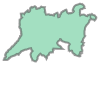

In [22]:
shapely.geometry.shape(dict(geom))

In [23]:
h3.hex_area(7, unit='m^2')

5161293.2

In [24]:
h3.hex_area(10, unit='m^2')

15047.5

In [25]:
h3.hex_area(12, unit='m^2')

307.09999999999997

In [26]:
h3.hex_area(15, unit='m^2')

0.8999999999999999

In [27]:
hexes = h3.polyfill(dict(geom), 12)
len(hexes)

35496

In [28]:
hexes_multigon = h3.h3_set_to_multi_polygon(hexes, geo_json=False)

In [29]:
polygon = {
    "type": "MultiPolygon",    
    "coordinates": hexes_multigon
}

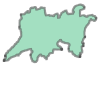

In [30]:
shapely.geometry.shape(polygon)

In [31]:
hexes = h3.polyfill(dict(geom), 11)
len(hexes)

5050

In [32]:
hexes_multigon = h3.h3_set_to_multi_polygon(hexes, geo_json=False)

In [33]:
polygon = {
    "type": "MultiPolygon",    
    "coordinates": hexes_multigon
}

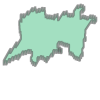

In [34]:
shapely.geometry.shape(polygon)

## Limit, Join, and Create Conformed Data with Geometry

In [35]:
philadelphia_county_zips = [
    19120,
    19124,
    19111,
    19143,
    19149,
    19134,
    19140,
    19148,
    19104,
    19144,
    19145,
    19131,
    19139,
    19146,
    19147,
    19115,
    19136,
    19128,
    19135,
    19121,
    19154,
    19141,
    19132,
    19152,
    19114,
    19116,
    19151,
    19138,
    19142,
    19119,
    19130,
    19125,
    19133,
    19103,
    19150,
    19122,
    19126,
    19123,
    19107,
    19106,
    19153,
    19129,
    19118,
    19137,
    19127,
    19102,
    19108,
    19109,
    19176,
    19112,
    19162,
    19161,
    19171,
    19170,
    19173,
    19172,
    19175,
    19178,
    19177,
    19181,
    19179,
    19183,
    19182,
    19185,
    19184,
    19188,
    19187,
    19192,
    19191,
    19194,
    19193,
    19196,
    19195,
    19244,
    19197,
    19255,
    19019,
    19093,
    19092,
    19101,
    19099,
    19105,
    19110,
    19160,
    19155,
    19190,
]
len(philadelphia_county_zips)

86

In [36]:
len(set(philadelphia_county_zips))

86

In [37]:
len(src)

33791

In [38]:
shape_data = [
    {
        **shape.properties,
        "geometry": dict(shape.geometry)
    }
    for shape in src
    if int(shape.properties["GEOID20"]) in philadelphia_county_zips
]    

In [39]:
len(shape_data)

49

In [40]:
extracted_zips = set([int(shape["GEOID20"]) for shape in shape_data])
expected_zips = set(philadelphia_county_zips)
expected_zips - extracted_zips

{19019,
 19092,
 19093,
 19099,
 19101,
 19105,
 19110,
 19155,
 19160,
 19161,
 19162,
 19170,
 19171,
 19172,
 19173,
 19175,
 19176,
 19177,
 19178,
 19179,
 19181,
 19182,
 19183,
 19184,
 19185,
 19187,
 19188,
 19190,
 19191,
 19192,
 19193,
 19194,
 19195,
 19196,
 19197,
 19244,
 19255}

In [41]:
# Inspection of the handful that are missing seem to not have geographic boundaries (and thus populations) associated with them
# Also the list of ZIP codes can from Zillow, which could be incorrect

In [42]:
shape_df = (
    pl.DataFrame(shape_data)
    .select(
        pl.col("ZCTA5CE20").cast(pl.Int32).alias("ZCTA5CE20"),
        pl.col("geometry"),
    )
)
shape_df

ZCTA5CE20,geometry
i32,struct[3]
19151,"{[[[-75.280266, 39.974964], [-75.27951, 39.975349], … [-75.280266, 39.974964]]],""Polygon"",null}"
19153,"{[[[-75.276904, 39.863685], [-75.272319, 39.864298], … [-75.276904, 39.863685]]],""Polygon"",null}"
19131,"{[[[-75.249768, 39.99029], [-75.249214, 39.990547], … [-75.249768, 39.99029]]],""Polygon"",null}"
19142,"{[[[-75.247759, 39.921708], [-75.24769, 39.921792], … [-75.247759, 39.921708]]],""Polygon"",null}"
19152,"{[[[-75.066116, 40.05277], [-75.066038, 40.052786], … [-75.066116, 40.05277]]],""Polygon"",null}"
…,…
19126,"{[[[-75.150943, 40.052266], [-75.150542, 40.052246], … [-75.150943, 40.052266]]],""Polygon"",null}"
19127,"{[[[-75.251298, 40.043505], [-75.250701, 40.043905], … [-75.251298, 40.043505]]],""Polygon"",null}"
19130,"{[[[-75.193724, 39.975285], [-75.19306, 39.975354], … [-75.193724, 39.975285]]],""Polygon"",null}"


In [43]:
census_data_execution_plan = updated_df.serialize()

In [44]:
census_data = updated_df.collect()

In [45]:
shape_df.shape

(49, 2)

In [46]:
merged_data = (
    shape_df
    .join(
        census_data,
        left_on=["ZCTA5CE20"],
        right_on=["ZCTA5"],
        how="inner",
    )
)

In [47]:
merged_data.shape

(49, 100)

In [48]:
@pl.api.register_expr_namespace("geo")
class Geometry:
    def __init__(self, expr: pl.Expr):
        self._expr = expr

    def polyfill(self, res: int) -> pl.Expr:
        return (self._expr.map_elements(lambda geom: list(h3.polyfill(geom, res)), return_dtype=pl.List(pl.String)))

In [49]:
final_data = merged_data.with_columns(
    pl.col("geometry").geo.polyfill(12).alias("Cells12"),
)

In [50]:
try:
    os.mkdir("../../data/common/US2020Census")
except FileExistsError as e:
    pass

In [51]:
final_data.write_parquet("../../data/common/US2020Census/US2020Census.parquet")

## Create Metadata

Main Attributes

- name
- publisher {"@id": "#local_id"} or {"@id": "url"}
- creater {"@id": "#person"}
- license
- datePublished
- keywords (ex. "streets, aggregated features, map")

Contextual

- Creator
    - @type Person
    - name
 
- Publisher
    - @type Organization
    - name
    - url

Dataset

- Upstream Dataset(s)
- Output Dataset (Main Entity)
- Provenance of Producing Output Dataset
    - This file (Since it can't be processed all the way through with polars)

In [52]:
crate = ROCrate()

In [53]:
name = "US 2020 Census Zip Population Data with Shapes for Philadelphia County"
short_name = "US2020Census"

In [54]:
author = crate.add(
    Person(
        crate,
        "Schneider, Richard",
        properties={
            "name": "Richard Schneider",
        },
    )
)

In [55]:
project = crate.add(
    ContextEntity(
        crate,
        "https://github.com/rschneider98/data_curation",
        properties={
            "@type": "Organization",
            "name": "Data Curation Project",
            "url": "https://github.com/rschneider98/data_curation"
        },
    )
)

In [56]:
us_public_domain = crate.add(
    ContextEntity(
        crate,
        "U.S. Public Domain",
        properties={
            "@type": "License",
            "name": "U.S. Public Domain",
            "url": "http://www.usa.gov/publicdomain/label/1.0/",
        },
    )
)

In [57]:
date_published = date.today().isoformat()

In [58]:
crate.name = name
crate.publisher = project
crate.creator = author
crate.license = us_public_domain
crate.datePublished = date_published
crate.keywords = ["US Census", "US Census ZCTA5", "Population", "Geometry"]

In [59]:
encoding_format = crate.add(
    ContextEntity(
        crate,
        "https://www.loc.gov/preservation/digital/formats/fdd/fdd000575.shtml",  # Apache Parquet does not exist in PRONOM
        properties={
            "@type": "Website",
            "name": "parquet",
        },
    )
)

In [60]:
# Dataset
out_file = crate.add (
    File(
        crate,
        source=f"file:///data/common/{short_name}/{short_name}.parquet",
        properties={
            "description": "U.S. 2020 Decennial Census for the Survey and Populations and People Zip Data with Shapes for Philadelphia County",
            "contentSize": get_file_size(f"../../data/common/{short_name}/{short_name}.parquet"),
            "encodingFormat": [encoding_format.properties()["name"], {"@id": encoding_format.id}],
        }
    )
)

out_dataset = crate.add(
    Dataset(
        crate,
        source=f"file:///data/common/{short_name}",
        properties={
            "description": "U.S. 2020 Decennial Census for the Survey and Populations and People Zip Data with Shapes for Philadelphia County",
            "hasParts": [
                {"@id": out_file.id},
            ]
        }
    )
)

In [61]:
# Main Entry
crate.mainEntity = out_dataset

### Consumed Datasets

In [62]:
# Upstream - Data
# in_crate_data
census_data_dataset = in_crate_data.mainEntity

In [63]:
in_census_dataset = crate.add(
    Dataset(
        crate,
        source=census_data_dataset.source,
        properties={
            "description": census_data_dataset.properties().get("description"),
            "name": in_crate_data.name,
            "sameAs": str(in_crate_data.source),
        }
    )
)

In [64]:
# Upstream - Shapes
# in_crate_shapes
census_shapes_dataset = in_crate_shapes.mainEntity

In [65]:
in_census_dataset = crate.add(
    Dataset(
        crate,
        source=census_shapes_dataset.source,
        properties={
            "description": census_shapes_dataset.properties().get("description"),
            "name": in_crate_shapes.name,
            "sameAs": str(in_crate_shapes.source),
        }
    )
)

In [66]:
# Provenance - This file
# ContextualEntity of Type Computational Workflow

In [67]:
python_language = crate.add(
    ContextEntity(
        crate,
        identifier="python",
        properties={
            "@type": ["ComputerLanguage", "SoftwareApplication"],
            "name": "Python 3.12.2",
            "version": "3.12.2",
            "url": "https://www.python.org/downloads/release/python-3122/",
        },
    )
)

In [68]:
workflow = crate.add(
    ComputationalWorkflow(
        crate,
        source="file:///analysis/Conform/Conform - Census Data.ipynb",
        properties={
            "author": {"@id": author.id},
            "programmingLanguage": {"@id": python_language.id},
        }
    )
)

In [69]:
action = crate.add(
    ContextEntity(
        crate,
        identifier="Conform - Census Data",
        properties={
            "@type": "CreateAction",
            "name": "Conform Census Data",
            "instrument": {"@id": workflow.id},
            "result": {"@id": out_dataset.id},
        },
    )
)

### Store Metadata

In [70]:
crate.write(f"../../metastore/{short_name}/")